# Growing Conditional Neural Cellular Automata [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/maxencefaldor/cax/blob/main/examples/41_growing_conditional_nca.ipynb)

## Installation

You will need Python 3.10 or later, and a working JAX installation. For example, you can install JAX with:

In [ ]:
%pip install -U "jax[cuda12]"

Then, install CAX from PyPi:

In [ ]:
%pip install -U "cax[examples]"

## Import

In [ ]:
import jax
import jax.numpy as jnp
import mediapy
import optax
import PIL
from flax import nnx
from tqdm.auto import tqdm

from cax.core.ca import CA
from cax.core.perceive import ConvPerceive, grad_kernel, identity_kernel
from cax.core.update import NCAUpdate
from cax.nn.pool import Pool
from cax.utils import clip_and_uint8, rgba_to_rgb
from cax.utils.emoji import get_emoji

## Configuration

In [41]:
seed = 42

channel_size = 32
num_kernels = 3
hidden_size = 256
cell_dropout_rate = 0.5

pool_size = 1_024
batch_size = 8
num_steps = 64
learning_rate = 1e-3

emojis = "🐶🐱🐭🐹🐰🦊🐻🐼"
size = 40
pad_width = 16

key = jax.random.key(seed)
rngs = nnx.Rngs(seed)

## Dataset


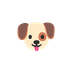
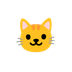
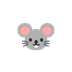
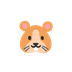
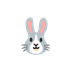
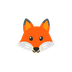
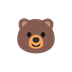
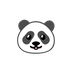

In [42]:
def get_y_from_emoji(emoji: str) -> jax.Array:
	"""Get target y from an emoji."""
	emoji_pil = get_emoji(emoji)
	emoji_pil = emoji_pil.resize((size, size), resample=PIL.Image.Resampling.LANCZOS)

	y = jnp.array(emoji_pil, dtype=jnp.float32) / 255.0
	y = jnp.pad(y, ((pad_width, pad_width), (pad_width, pad_width), (0, 0)))

	return y


y = jnp.array([get_y_from_emoji(emoji) for emoji in emojis])
z = jnp.eye(y.shape[0])

mediapy.show_images(y, width=128, height=128)

## Model

In [ ]:
perceive = ConvPerceive(
	channel_size=channel_size,
	perception_size=num_kernels * channel_size,
	rngs=rngs,
	feature_group_count=channel_size,
)
update = NCAUpdate(
	channel_size=channel_size,
	perception_size=y.shape[0] + num_kernels * channel_size,
	hidden_layer_sizes=(hidden_size,),
	rngs=rngs,
	cell_dropout_rate=cell_dropout_rate,
	zeros_init=True,
)

In [10]:
class GrowingConditionalNCA(CA):
	"""Growing Conditional Neural Cellular Automata."""

	def __init__(self, perceive, update):
		"""Initialize Growing Conditional NCA."""
		super().__init__(perceive, update)

		# Initialize kernel with sobel filters
		kernel = jnp.concatenate([identity_kernel(ndim=2), grad_kernel(ndim=2)], axis=-1)
		kernel = jnp.expand_dims(jnp.concatenate([kernel] * channel_size, axis=-1), axis=-2)
		self.perceive.conv.kernel = nnx.Param(kernel)

	@nnx.jit
	def step(self, state, input):
		"""Perform a single step."""
		# Broadcast the input vector to match the state shape
		input_shape = (*state.shape[:-1], input.shape[-1])
		input = jnp.broadcast_to(input[..., None, None, :], input_shape)

		# Step
		perception = self.perceive(state)
		next_state = self.update(state, perception, input)

		return next_state, self.metrics_fn(next_state, state, perception, input)

	@nnx.jit
	def render(self, state):
		"""Render state to RGB."""
		rgba = state[..., -4:]
		rgb = rgba_to_rgb(rgba)

		# Clip values to valid range and convert to uint8
		return clip_and_uint8(rgb)

	@nnx.jit
	def render_rgba(self, state):
		"""Render state to RGBA."""
		rgba = state[..., -4:]

		# Clip values to valid range and convert to uint8
		return clip_and_uint8(rgba)

In [11]:
ca = GrowingConditionalNCA(perceive, update)

In [12]:
params = nnx.state(ca, nnx.Param)
print("Number of params:", sum(x.size for x in jax.tree.leaves(params)))

Number of params: 35968


## Sample initial state

In [14]:
def sample_state(key):
	"""Sample a state with a single alive cell."""
	spatial_dims = y.shape[1:3]

	# Init state
	state = jnp.zeros(spatial_dims + (channel_size,))
	mid = tuple(size // 2 for size in spatial_dims)

	# Set the center cell to alive
	state = state.at[mid[0], mid[1], -1].set(1.0)

	# Sample a random target y
	y_idx = jax.random.choice(key, y.shape[0])
	return state, y_idx

## Train

### Pool

In [15]:
key, subkey = jax.random.split(key)

keys = jax.random.split(subkey, pool_size)
state, y_idx = jax.vmap(lambda key: sample_state(key))(keys)

pool = Pool.create({"state": state, "y_idx": y_idx})

### Optimizer

In [16]:
lr_sched = optax.linear_schedule(
	init_value=learning_rate, end_value=0.1 * learning_rate, transition_steps=50_000
)

optimizer = optax.chain(
	optax.clip_by_global_norm(1.0),
	optax.adam(learning_rate=lr_sched),
)

update_params = nnx.All(nnx.Param, nnx.PathContains("update"))
optimizer = nnx.Optimizer(ca, optimizer, wrt=update_params)

### Loss

In [17]:
def mse(state, y):
	"""Mean Squared Error."""
	return jnp.mean(jnp.square(state[..., -4:] - y))

In [18]:
@nnx.jit
def loss_fn(ca, state, z, y, key):
	"""Loss function."""
	state_axes = nnx.StateAxes({nnx.RngState: 0, ...: None})
	_, state = nnx.split_rngs(splits=batch_size)(
		nnx.vmap(
			lambda ca, state, z: ca(state, z, num_steps=num_steps),
			in_axes=(state_axes, 0, 0),
		)
	)(ca, state, z)

	# Sample a random step
	idx = jax.random.randint(key, (batch_size,), num_steps // 2, num_steps)
	state = state[jnp.arange(batch_size), idx]

	loss = mse(state, y)
	return loss, state

### Train step

In [19]:
@nnx.jit
def train_step(ca, optimizer, pool, key):
	"""Train step."""
	sample_key, sample_state_key, loss_key = jax.random.split(key, 3)

	# Sample from pool
	pool_idx, batch = pool.sample(sample_key, batch_size=batch_size)
	current_state = batch["state"]
	current_y_idx = batch["y_idx"]
	current_y = y[current_y_idx]

	# Sort by descending loss
	sort_idx = jnp.argsort(jax.vmap(mse)(current_state, current_y), descending=True)
	pool_idx = pool_idx[sort_idx]
	current_state = current_state[sort_idx]
	current_y_idx = current_y_idx[sort_idx]

	# Sample a new state to replace the worst
	new_state, new_y_idx = sample_state(sample_state_key)
	current_state = current_state.at[0].set(new_state)
	current_y_idx = current_y_idx.at[0].set(new_y_idx)
	current_y = y[current_y_idx]
	current_z = z[current_y_idx]

	(loss, current_state), grad = nnx.value_and_grad(
		loss_fn, has_aux=True, argnums=nnx.DiffState(0, update_params)
	)(ca, current_state, current_z, current_y, loss_key)
	optimizer.update(grad)

	pool = pool.update(pool_idx, {"state": current_state, "y_idx": current_y_idx})
	return loss, pool

### Main loop

In [ ]:
num_train_steps = 8_192
print_interval = 128

pbar = tqdm(range(num_train_steps), desc="Training", unit="train_step")
losses = []
for i in pbar:
	key, subkey = jax.random.split(key)
	loss, pool = train_step(ca, optimizer, pool, subkey)
	losses.append(loss)

	if i % print_interval == 0 or i == num_train_steps - 1:
		avg_loss = sum(losses[-print_interval:]) / len(losses[-print_interval:])
		pbar.set_postfix({"Average Loss": f"{avg_loss:.3e}"})

## Run

In [24]:
key, subkey = jax.random.split(key)

keys = jax.random.split(subkey, y.shape[0])
state_init, _ = jax.vmap(sample_state)(keys)

state_axes = nnx.StateAxes({nnx.RngState: 0, ...: None})
state_final, states = nnx.split_rngs(splits=y.shape[0])(
	nnx.vmap(
		lambda ca, state, z: ca(state, z, num_steps=2 * num_steps),
		in_axes=(state_axes, 0, 0),
	)
)(ca, state_init, z)

## Visualize

In [25]:
states = jnp.concatenate([state_init[:, None], states], axis=1)
frames = jax.vmap(ca.render)(states)
frames_final = jax.vmap(ca.render)(state_final)
frames_final_rgba = jax.vmap(ca.render_rgba)(state_final)


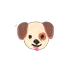
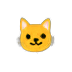
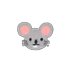
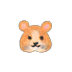
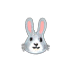
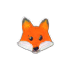
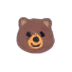
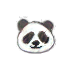


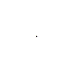
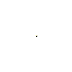
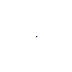
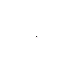
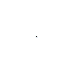
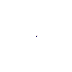
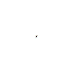
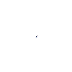

In [55]:
mediapy.show_images(frames_final_rgba, width=128, height=128)
mediapy.show_videos(frames, width=128, height=128, codec="gif")

## Interpolation

### Dog-Panda


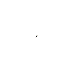

In [56]:
# Define latent encoding
z_dog_panda = jnp.array([0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5])

# Sample initial state
key, subkey = jax.random.split(key)
state_init, _ = sample_state(subkey)

# Run
_, states = ca(state_init, z_dog_panda, num_steps=2 * num_steps)

# Visualize
states = jnp.concatenate([state_init[None], states])
frames = jax.vmap(ca.render)(states)

mediapy.show_video(frames, width=128, height=128, codec="gif")

### Fox-Panda


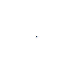

In [59]:
# Define latent encoding
z_fox_panda = jnp.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.5])

# Sample initial state
key, subkey = jax.random.split(key)
state_init, _ = sample_state(subkey)

# Run
_, states = ca(state_init, z_fox_panda, num_steps=2 * num_steps)

# Visualize
states = jnp.concatenate([state_init[None], states])
frames = jax.vmap(ca.render)(states)

mediapy.show_video(frames, width=128, height=128, codec="gif")

### Cat-Panda

In [ ]:
# Define two target images
cat_index = 1
panda_index = 7

# Interpolate between the two latent encodings
num_interpolations = 8
alphas = jnp.linspace(0.0, 1.0, num_interpolations)
z_interpolation = jnp.array(
	[(1.0 - alpha) * z[cat_index] + alpha * z[panda_index] for alpha in alphas]
)

# Sample initial state
key, subkey = jax.random.split(key)
state_init, _ = sample_state(subkey)

# Run
state_axes = nnx.StateAxes({nnx.RngState: 0, ...: None})
final_states, _ = nnx.split_rngs(splits=alphas.shape[0])(
	nnx.vmap(
		lambda ca, state, z: ca(state, z, num_steps=2 * num_steps),
		in_axes=(state_axes, None, 0),
	)
)(ca, state_init, z_interpolation)


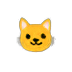
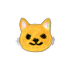
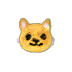
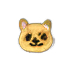
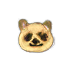
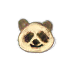
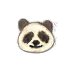
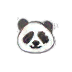

In [60]:
frames = jax.vmap(ca.render_rgba)(final_states)

mediapy.show_images(frames, width=128, height=128)